In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/Train')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [136]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [179]:
S_PREFIX = 'multi'

### Create dataloader

In [103]:
def convert_y(y_img):
    yv = y_img[:,:,2]==VEHICLES
    cutoff_y = int(yv.shape[0]*.83)
    yv[cutoff_y:,:] = 0
    
    yr = (y_img[:,:,2]==ROADS) | (y_img[:,:,2]==ROAD_LINES)
    ynone = ~(yv | yr)
    
    return np.dstack((yv,yr,ynone)).astype(int)

In [147]:
def convert_y(y_img):
    y_new = np.zeros(y_img.shape, dtype=int)
    y_new[y_img[:,:,2]==VEHICLES] = 1
    # yv = y_img[:,:,2]==VEHICLES
    cutoff_y = int(y_new.shape[0]*.83)
    y_new[cutoff_y:,:,:] = 0

    y_new[y_img[:,:,2]==ROADS] = 2
    y_new[y_img[:,:,2]==ROAD_LINES] = 2
    return y_new

In [148]:
def open_y_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            im = cv2.imread(str(fn), flags)
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
#             return im
            return convert_y(im)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [165]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): 
        return open_y_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0
    def get(self, tfm, x, y):
        x,y = super().get(tfm, x, y)
#         y = (y[2,:,:]==VEHICLES).astype(np.float32)
        return x,y[0]

In [166]:
def get_data(train_path, mask_path, bs):
    x_names = np.array(glob(str(PATH/TRAIN_DN/'*.png')))
    y_names = np.array(glob(str(PATH/MASKS_DN/'*.png')))
    val_idxs = list(range(100))
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    aug_tfms = [
        RandomRotate(4, tfm_y=TfmType.CLASS),
        RandomFlip(tfm_y=TfmType.CLASS),
        RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)
    ]
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path='')
    md = ImageData(PATH, datasets, bs, num_workers=7, classes=None)
    denorm = md.trn_ds.denorm
    return md

In [167]:
def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## Simple upsample

In [108]:
f = resnet34
cut,lr_cut = model_meta[f]

In [72]:
x,y = next(iter(md.trn_dl))

In [109]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

## U-net (ish)

In [110]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [152]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [153]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [154]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [155]:
def get_learner(md):
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.CrossEntropyLoss()
#     learn.crit = nn.BCEWithLogitsLoss()
    learn.metrics=[new_acc, dice_mult]
    return learn

In [168]:
TRAIN_DN = 'CameraRGB-128'
MASKS_DN = 'CameraSeg-128'
sz = 128
bs = 64

In [169]:
md = get_data(TRAIN_DN, MASKS_DN, bs)

In [170]:
learn = get_learner(md)

In [171]:
x,y = next(iter(md.trn_dl))

In [174]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   new_acc    dice_mult      
    0      1.236445   2.6918281225603426e+23 0.589257   0.602837  



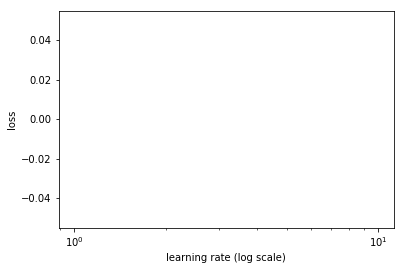

In [175]:
learn.lr_find()
learn.sched.plot()

In [176]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [177]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   new_acc    dice_mult      
    0      0.586293   47.441782  0.212649   0.69471   
    1      0.290087   1.291025   0.74618    1.453988       
    2      0.185261   0.079426   0.971963   1.883833       
    3      0.132067   0.044437   0.984229   1.915704       
    4      0.099652   0.027353   0.990654   1.940164        
    5      0.079415   0.024991   0.991541   1.944595        
    6      0.065021   0.026408   0.990931   1.940454        
    7      0.055028   0.023415   0.991948   1.94412         



[array([0.02342]), 0.9919482517242432, 1.9441201601137927]

In [180]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [181]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [182]:
learn.unfreeze()
learn.bn_freeze(True)

In [183]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.027105   0.024845   0.991271   1.941492  
    1      0.027132   0.019835   0.993086   1.948673        
    2      0.026101   0.019527   0.993135   1.950636        
    3      0.025271   0.019766   0.992952   1.947266        
    4      0.024392   0.017653   0.993759   1.951248        
    5      0.023913   0.017501   0.993708   1.95103         
    6      0.023297   0.017503   0.993802   1.950309        
    7      0.022978   0.016905   0.993956   1.952315        
    8      0.022526   0.01678    0.994014   1.951489        
    9      0.022281   0.01662    0.994072   1.952124        



[array([0.01662]), 0.9940722632408142, 1.9521237187309408]

In [184]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.020918   0.016955   0.99385    1.950797  
    1      0.021874   0.01774    0.993619   1.949532        
    2      0.021846   0.016438   0.994067   1.950996        
    3      0.021406   0.015768   0.994345   1.953202        
    4      0.020823   0.015392   0.994451   1.954098        
    5      0.020608   0.01547    0.994374   1.954749        
    6      0.020412   0.015147   0.994515   1.952989        
    7      0.019925   0.014894   0.994639   1.954159        
    8      0.019616   0.01483    0.99463    1.953604        
    9      0.01907    0.01463    0.994696   1.954012        



[array([0.01463]), 0.9946960401535034, 1.9540122743766606]

In [185]:
learn.save(f'128urn-{S_PREFIX}-0')

In [186]:
learn.load(f'128urn-{S_PREFIX}-0')

In [187]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [189]:
py = np.argmax(py,1)

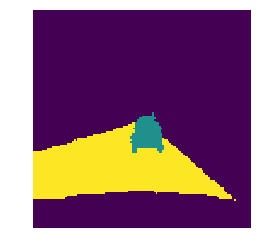

In [190]:
show_img(py[0]);

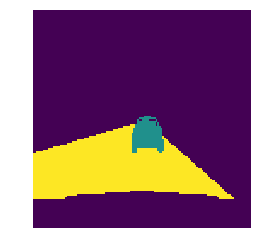

In [191]:
show_img(y[0]);

## 256x256

In [193]:
TRAIN_DN = 'CameraRGB-256'
MASKS_DN = 'CameraSeg-256'
sz=256
bs=64

In [194]:
md = get_data(TRAIN_DN, MASKS_DN, bs)

In [195]:
lr=2e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [196]:
learn = get_learner(md)

In [197]:
learn.freeze_to(1)

In [198]:
learn.load(f'128urn-{S_PREFIX}-0')

In [199]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc    dice_mult      
    0      0.103847   0.10213    0.96101    1.816229  
    1      0.063727   0.021965   0.992497   1.94622         
    2      0.047      0.020989   0.992612   1.947804        
    3      0.037754   0.018242   0.993574   1.951524        
    4      0.031993   0.015257   0.994745   1.954522        
    5      0.028174   0.014184   0.99506    1.955048        
    6      0.0251     0.013345   0.995359   1.956517        
    7      0.022986   0.012509   0.995592   1.957035        
    8      0.021431   0.012288   0.995661   1.957486        
    9      0.019917   0.011833   0.995826   1.95704         



[array([0.01183]), 0.9958256459236146, 1.9570402758583882]

In [200]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [201]:
learn.unfreeze()
learn.bn_freeze(True)

In [202]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [203]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.015316   0.01187    0.995678   1.956621  
    1      0.015289   0.012278   0.995532   1.955263        
    2      0.014948   0.01129    0.995887   1.957208        
    3      0.014815   0.011324   0.995858   1.956891        
    4      0.014607   0.010812   0.996055   1.958158        
    5      0.014273   0.010871   0.996035   1.958829        
    6      0.014145   0.01058    0.996152   1.958331        
    7      0.014071   0.010589   0.996142   1.95833         



[array([0.01059]), 0.9961418151855469, 1.9583295654465018]

In [204]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult       
    0      0.013392   0.010711   0.996067   1.957741  
    1      0.013663   0.011746   0.995633   1.956573        
    2      0.013573   0.010519   0.99613    1.957989        
    3      0.013432   0.010114   0.996301   1.958477        
    4      0.013209   0.009975   0.996335   1.958826        
    5      0.013124   0.009895   0.996367   1.959013        
    6      0.01313    0.010078   0.996272   1.958948        
    7      0.013076   0.009913   0.996328   1.95924         



[array([0.00991]), 0.9963275122642518, 1.9592399038390127]

In [205]:
learn.save(f'256urn-{S_PREFIX}')

In [206]:
learn.load(f'256urn-{S_PREFIX}')

In [207]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [208]:
py = np.argmax(py,1)

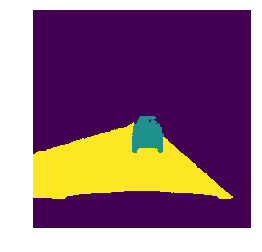

In [209]:
show_img(py[0]);

In [ ]:
show_img(y[0]);

In [ ]:
m.close()

## 512x512

In [210]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
sz=608
bs=8

In [211]:
md = get_data(TRAIN_DN, MASKS_DN, bs)

In [212]:
learn = get_learner(md)

In [213]:
learn.load(f'256urn-{S_PREFIX}')

In [214]:
learn.freeze_to(1)

In [215]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [216]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(5,4))

epoch      trn_loss   val_loss   new_acc    dice_mult         
    0      0.027387   0.075151   0.982108   1.918053  
    1      0.020625   0.014632   0.994726   1.951558          
    2      0.014719   0.010678   0.995967   1.95706           
    3      0.011682   0.008608   0.996776   1.959535          



[array([0.00861]), 0.996775815486908, 1.9595345028958817]

In [217]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [218]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [219]:
learn.unfreeze()
learn.bn_freeze(True)

In [220]:
lrs = np.array([lr/200,lr/30,lr])

In [221]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult         
    0      0.01031    0.008065   0.996886   1.960815  
    1      0.009838   0.008014   0.996888   1.959588           
    2      0.009449   0.007605   0.997084   1.961087           
    3      0.009217   0.007399   0.997143   1.96078            



[array([0.0074]), 0.9971428370475769, 1.9607798166269714]

In [222]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice_mult          
    0      0.009338   0.007202   0.997219   1.960867  
    1      0.008906   0.007354   0.997186   1.960657           
    2      0.008682   0.007247   0.997203   1.960539           
    3      0.008573   0.007157   0.997257   1.961255           



[array([0.00716]), 0.997257239818573, 1.961254934191997]

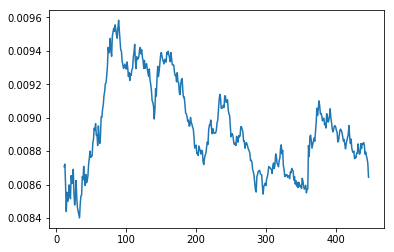

In [223]:
learn.sched.plot_loss()

In [224]:
learn.save(f'600urn-{S_PREFIX}')

In [26]:
learn.load(f'600urn-{S_PREFIX}')

In [27]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

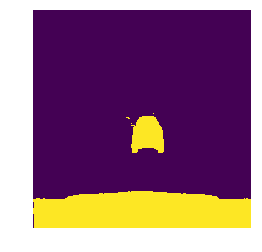

In [28]:
show_img(py[0]>0);

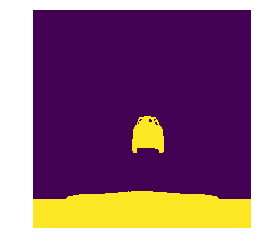

In [29]:
show_img(y[0]);

## Save results

In [225]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [226]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [227]:
# model_summary(m, [3,608,800])

In [228]:
# learn.load('1024urn')
load_model(m, str(PATH/f'models/600urn-{S_PREFIX}.h5'))

In [229]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [230]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [231]:
def normalize(x):
    if np.mean(x) > 1:
        x = x/255
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [232]:
f1 = preprocess(video)

In [234]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
    mx,idx = torch.max(preds, 1)
    idx_slice = idx[:,:-8,:]
    results.append(idx_slice)

In [235]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [236]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

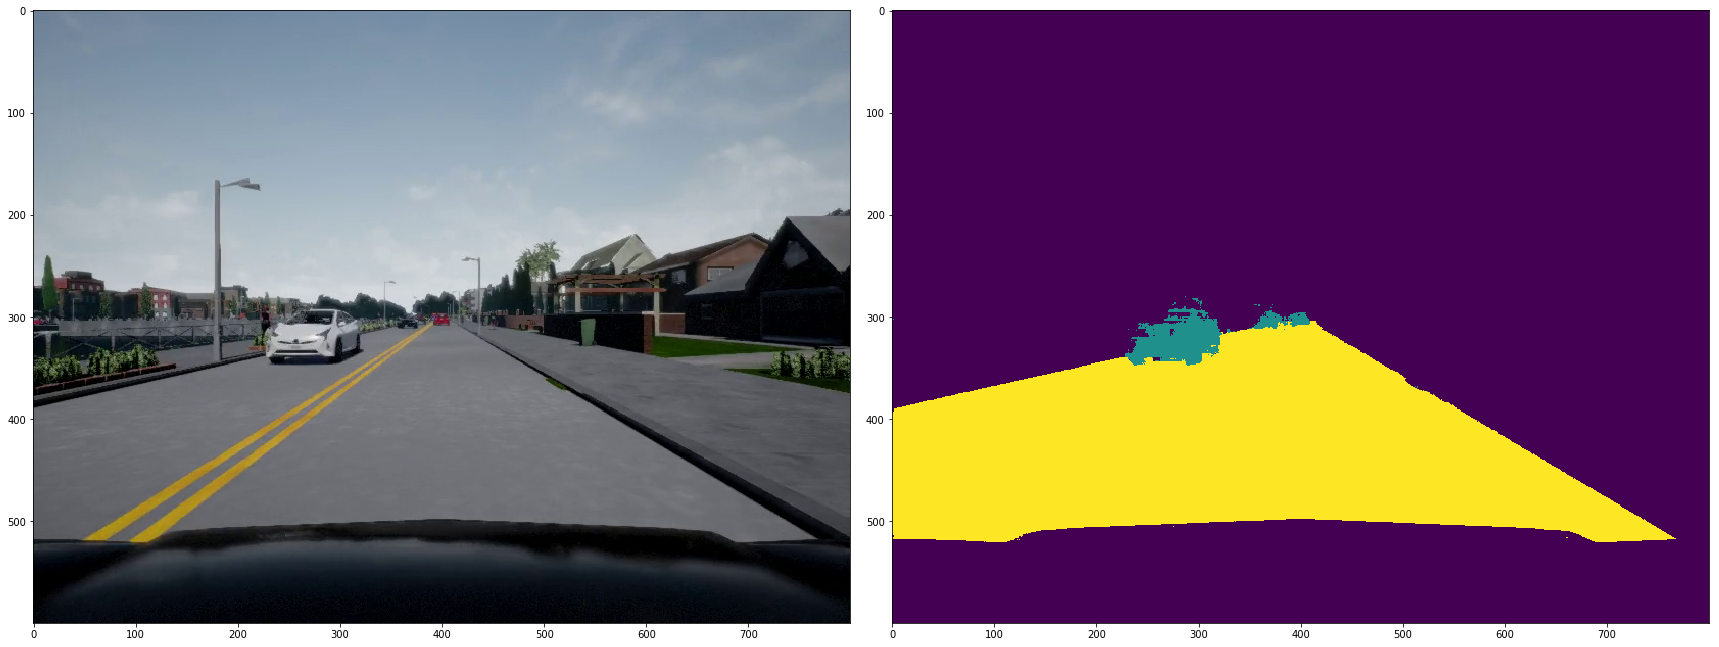

In [237]:
plot_res(10)

In [243]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==2).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_multi_take2', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

{"1": ["iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYCAAAAAC/Hd2sAAAECklEQVR4nO3dWXLrIBAAQCaV+1953ocXOdZirc8CdX/E5a2KgIYBhORSAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJgpvl0A9qdRd9FVY36xFOtFpeU+3u+3C9COvIVJ1Bgk9ZX4fxEgO8ryzCXhkGuDANlJvj4auDbj59sFaEG8B0SWEm9h0vsMVRAgB8n3NGLMVSX92kaPCuwf/zHyOjWRQY6TgqN+Msih7lkkyjOVxP1pfxAmnM5IBjlQvD0OP/3wMl+lVbb5eL7jWcH5t7Kz9CtfDjkfGWSL+9rt3wN9XoIIfVMVtNIm0V/OLaXc5he5sG7ljzOSQbaIMtHF6HtaIEA2mIwPmvAWIJp7vqnNIx/r0TmSSvxGlhL5WIx5aTb7UWfq6mlB96InqsRPllJyaKNEasU58nkCUG21aHKKebUcMjtpfo6FpUtYty+t+A7HisGrLSPj2cJareeoXKGqzyf68dFFxhWzyBx7BIgz6XX46S+ndKNqDiEOKjJ4yW2W+3j8tsKlRf9a1HN0g9Vu1SMfd3fg9CZPFD6ur45wwWhn8w6SKDmyQ4XT0UxrzKy1vK+LDc3l4mUWkiOf4ftsNTnQ54XAzJK3OV+Kj1OSQVaYW2mO+PrJIDBBgKwwMzNIIA0QICsYl16HAFlBargOAbKCDHId

### Decoding car

In [239]:
PATH

PosixPath('../data/Train')

In [240]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [241]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


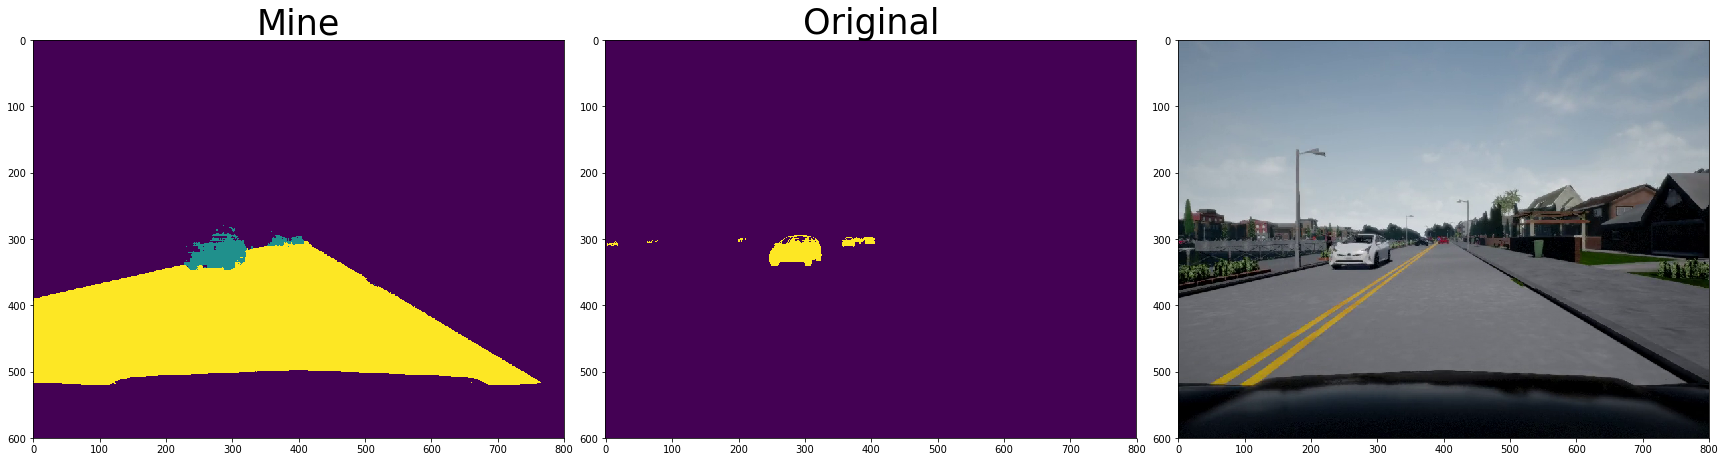

In [242]:
plot_ans(10)

In [49]:
ans = decode(ans_data['1'][0])

NameError: name 'misc' is not defined

In [50]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()